# Fitting weighted histograms

If histograms are filled with weighted data, we need to construct cost functions that handle this case correctly. Particularly troublesome is when bins contain a negative sum of weights, which can occur randomly if weights are partially negative, like sweights.

Bohm and Zech showed a way to fit weighted histograms, but their approach formally only works if the sum of weights is non-negative. Here, we discuss the ideas behind the cost functions that iminuit uses for weighted histograms, and how to generalize the Bohm-Zech approach to bin entries that are negative. This work is based and references the following papers:

- [1] Baker & Cousins, NIM 221 (1984) 437-442
- [2] Bohm and Zech, NIMA 748 (2014) 1-6
- [3] H. Dembinski, M. Schmelling, R. Waldi, NIMA 940 (2019) 135-141.

## Baker-Cousins transform

The maximum-likelihood method is widely very successful, and its qualities shine in particular in the application to Poisson-distributed data, because maximizing the likelihood yields an unbiased estimate of models fitted to this data [3], while naive least-squares does not unless one uses a special iterative scheme.

In constrast to least-squares methods, maximizing the likelihood does not yield a chi-square distributed minimum value, that can be used as a goodness-of-fit test statistic. Baker and Cousins [1] showed that the log-likelihood for Poisson distributed data can be replaced by a delta-log-likelihood, which has this property and is otherwise equivalent. One essentially adds a constant to the log-likelihood, which does not change the location of the minimum. For a single bin in a histogram, one can derive the following statistic, which is also known as the Cash statistic:

$$
\ell_\text{poisson}(n; \mu) = 2 [n (\ln(n) - \ln(\mu)) - \mu + n]
$$

It can be minimized to obtain an unbiased estimate for $\mu$, and the minimum value is asymptotically chi-square distributed and serves as a goodness-of-fit test statistic. The case $n = 0$ is handled by formally extending the integer realm to the real realm, and realizing that $x \ln x \to 0$ for $x\to 0$. In other words, in case of $n = 0$, $n \ln n$ has to be replaced by 0.

Furthermore, this form is beneficial for numerical computation on a computer, because near the minimum we have $\mu \approx n$ and $\ell_\text{poisson}(n;\mu) \approx 0$. This means that the sum $\sum_k \ell_\text{poisson}(n_k;\mu_k)$ over $k$ bins grows slowly and adds terms of similar size, which is ideal from the point of view of accuracy in floating point arithmetic.

As shown by Baker & Cousins, a similar statistic with the same nice properties can be derived from the log-likelihood for multinomially-distributed data:

$$
\ell_\text{multinomial}(n; \mu) = 2 [n (\ln(n) - \ln(\mu))]
$$

We further note that $\ell_\text{multinomial}$ and $\ell_\text{poisson}$ are equivalent for multinomially-distributed data. Because $\sum_k \mu_k = \sum_k n_k$ is always guaranteed, if the sum goes over all $k$ bins, the terms $n_k - \mu_k$ always sum up to zero, so they can be removed altogether.

## Bohm-Zech transform

Bohm and Zech proposed the scaled Poisson distribution (SPD) as an approximate way to handle sums of weights instead of Poisson counts. This approach also works for multinomially distributed data, as we will see later. The idea of the Bohm and Zech is to use the likelihood for Poisson distributed data also for weighted data. They match the first and second moment of the compound Poisson distribution for weighted data with a single Poisson distribution through a scaling factor $s$, that is multiplied with the prediction and the observation.

The scaling factor is computed as $s = \sum_i w_i / \sum_i w_i^2$, where $w_i$ are the weights in the current bin. Instead of the Baker & Cousins transformed log-likelihood $\ell(n; \mu)$ for Poisson-distributed data, where $n$ is the observed count and $\mu$ is the expectation, we now compute $\ell(s w; s \mu)$ with $w = \sum_i w_i$. This can be further simplified:

$$
\begin{aligned}
\ell_\text{poisson}(s w; s \mu) &= 2 [(s w) (\ln(s w) - \ln(s \mu)) - s \mu + s w] \\
&= 2 s [w (ln(w) - ln(\mu)) - \mu + w] \\
&= s \, \ell_\text{poisson}(w; \mu)
\end{aligned}
$$

Eventually, we find that the normal delta-log-likelihood gets scaled by the factor $s$. Note that we did transformations here that are only allowed for $s > 0$ and $w > 0$, otherwise the logarithms are not defined. The case $w = 0$ can be included in the same way as $n = 0$ by replacing $w \ln w$ with 0.

### Handling $s=0$

Often, $w = 0$ also implies $\sum w_i^2 = 0$. In that case $s$ becomes undefined. There is no elegant solution for this, because we need to know the true value of $s$ to perform a correct scaling, but we cannot get it empirically, as there is no data.

One might consider setting $s$ to 0 or 1, but these choices lead to problems. Using $s=0$ implies that empty bins cannot pull the prediction $\mu$ down, which would result in $\mu$ values that are overestimated. Similarly, $s=1$ may introduce a too strong pull if the average value of $s$ for the other bins is much smaller than 1, or too little if that average is way larger than 1. We cannot simply use the average value of $s$ either, because $s$ may vary systematically from bin-to-bin. This variation may not even be predictable.

In iminuit, we use the median of $s$ values from bins with entries, which will reduce the bias in at least some scenarios, but in general, practitioners should avoid empty bins in weighted histograms altogether.

### Multinomially-distributed weighted data

While it is irrelvant whether we use $\ell_\text{multinomial}$ or $\ell_\text{poisson}$ for ordinary multinomially-distributed data, the situation becomes different when weights are involved. If we consider weighted data and apply the Bohm-Zech transform, we find that $\ell_\text{multinomial}(s w; s \mu) \neq \ell_\text{poisson}(s w; s \mu)$. This is because $\sum_k s_k (w_k - \mu_k) \neq 0$ in general, even if $\sum_k (w_k - \mu_k) = 0$ holds. Numerical experiments confirm that $\ell_\text{multinomial}(s w; s \mu)$ yields biased results, the correct cost function for weighted multinomial data is therefore $\ell_\text{poisson}(s w; s \mu)$.

### Extension to datasets with negative sums of weights

The Bohm-Zech formula is only applicable if $w = \sum_i w_i \ge 0$ (with the extra condition that we
discussed), but formally fails if $w < 0$. Since $\sum_i w_i^2$ is always non-negative, $w < 0$ implies $s < 0$.

Our extension of $\ell_\text{poisson}(s w; s \mu)$ to this case is to use $s = |\sum_i w_i| / \sum_i w_i^2$ and replace $w \ln (w)$ with 0 for $w \le 0$.

This solution works, because it has the same gradient as a sum of squared studentized residuals $\sum_k s_k (w_k - \mu_k)^2/\mu'_k$, where $\mu'_k$ approaches $\mu_k$ in successive iterations, but is fixed during the gradient computation [3]. We know from the Gauss-Markov-Aitken theorem that the minimum of this quadratic function yields an unbiased estimate of $\mu_k$, if there are no additional constraints on $\mu_k$. Here, we have the constraint $\mu_k > 0$, so this won't be perfectly unbiased for very small $\mu_k$, but otherwise. Since the quadratic function and the original function have the same gradient, the minima of both functions are the same, and the original function also yields an unbiased or a low-bias estimate for very small $\mu_k$.

We mention the sum of squared studentized residuals, because it provides better intuitive insight. For example, it is clear that $s$ should be positive, since it acts as a modifier of the variance, effectively replacing $\mu'$ with $\mu'/s$. A negative $s$ cannot fulfill this purpose. Also, a negative $s_k$ would allow us to reduce the sum by making the disagreement between $w_k$ and $\mu_k$ larger, which is contradictory.

The gradient is not affected by the particular choice of replacing $w \ln(w)$ with 0 for $w < 0$, any other constant would also do, since this term drops out in the computation of the gradient. Our choice is motivated by the goal to keep the function minimum approximately chi-square distributed, although that property generally dissolves when negative weights are involved. The delta-log-likelihood compares the expectation from the model with the expectation from the so-called saturated model, but the definition of the latter breaks down for $w < 0$. Our ad hoc choices cannot fix that. The function minimum value can even become negative.


Let's visualize variations of $\ell_\text{poisson}$ for a signle bin and a couple of $w$ values, with $w^2 = 1$.

* `l1`: This is the chosen extension of $\ell_\text{poisson}$ as discussed above, with $s = |\sum_i w_i| / \sum_i w_i^2$, and $w \ln w$ replaced by 0 for $w < 0$.
* `l2`: Like `l1`, but we replace $w \ln w$ with $w \ln|w|$.
* `l3`: Like `l2`, but we use $s = \sum_i w_i / \sum_i w_i^2$.

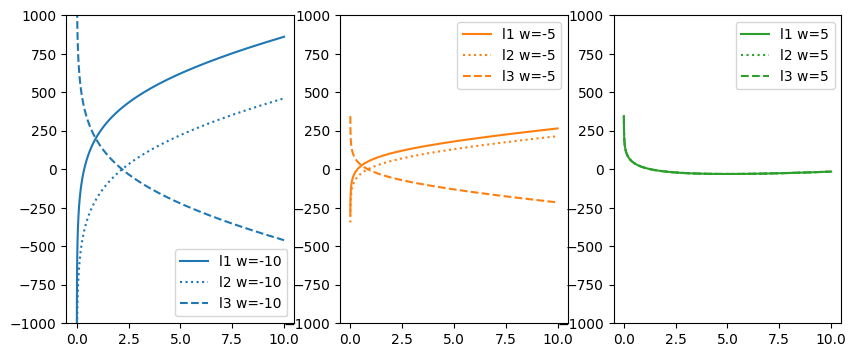

In [26]:
import numpy as np
import matplotlib.pyplot as plt


def log_or_zero(x):
    x = np.atleast_1d(x).copy()
    ma = x > 0
    x[ma] = np.log(x[ma])
    x[~ma] = 0
    return x


def l1(w, w2, mu):
    s = np.abs(w) / w2
    return 2 * s * (w * (log_or_zero(w) - log_or_zero(mu)) + mu - w)


def l2(w, w2, mu):
    s = np.abs(w) / w2
    return 2 * s * (w * log_or_zero(np.abs(w)) - w * log_or_zero(mu) + mu - w)


def l3(w, w2, mu):
    s = w / w2
    return 2 * s * (w * (log_or_zero(np.abs(w)) - log_or_zero(mu)) + mu - w)


w2 = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, (axi, w) in enumerate(zip(ax, (-10, -5, 5))):
    mu = np.geomspace(1e-3, 10, 100)
    color = f"C{i}"
    plt.sca(axi)
    plt.plot(mu, l1(w, w2, mu), color=color, label=f"l1 w={w}")
    plt.plot(mu, l2(w, w2, mu), color=color, ls=":", label=f"l2 w={w}")
    plt.plot(mu, l3(w, w2, mu), color=color, ls="--", label=f"l3 w={w}")
    plt.ylim(-1000, 1000)
    plt.legend()

All cost functions only differ for $w < 0$. `l3` is contradictory, since it prefers an infinite value of $\mu$ for $w < 0$. Both `l1` and `l2` prefer $\mu = 0$, which is correct. The vertical offset between `l1` and `l2` grows as $w$ becomes more negative. For both `l1` and `l2`, the function value at the minimum can become arbitrarily negative, something that never happens for $w > 0$ and should not happen for a chi-square-distributed variable. For $w < 0$, we cannot ensure this property, and hence function minimum value is no longer chi-square distributed. It can still qualitatively used as a GoF test statistic, as we will see below.

## Toy experiments

We illustrate these ideas with toy experiments. We generate data from an exponential distribution whose samples are weighted with a normal distribution. To make the toy more interesting, the width of the normal distribution is a function of the value realised by the exponential distribution. We then form weighted histograms from these data. The average weight per bin is constant, but the variance of the weights increases.

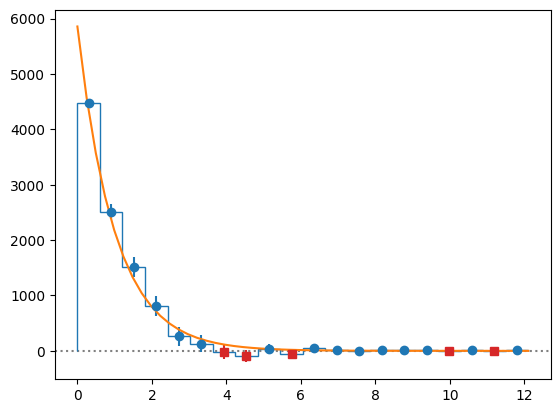

In [27]:
from iminuit.cost import BinnedNLL, ExtendedBinnedNLL
from iminuit import Minuit
from scipy.stats import expon, norm, chi2
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
from joblib import Parallel, delayed

rng = np.random.default_rng(1)

npoints = 100000
bins = 20

x = expon.rvs(size=npoints, random_state=rng)
w = norm.rvs(0.1, x, size=len(x), random_state=rng)

h = bh.Histogram(
    bh.axis.Regular(bins, np.min(x), np.max(x)), storage=bh.storage.Weight()
)
h.fill(x, weight=w)

plt.stairs(h.values(), h.axes[0].edges)
ma = h.values() > 0
plt.errorbar(
    h.axes[0].centers[ma], h.values()[ma], h.variances()[ma] ** 0.5, fmt="o", color="C0"
)
plt.errorbar(
    h.axes[0].centers[~ma],
    h.values()[~ma],
    h.variances()[~ma] ** 0.5,
    fmt="s",
    color="C3",
)
plt.axhline(0, ls=":", color="0.5", zorder=0)
xm = np.linspace(0, h.axes[0].edges[-1])
plt.plot(xm, expon.pdf(xm) * npoints * np.mean(w) * h.axes[0].widths[0]);

The line shows the true density, and the data points show the outcome of the sample. Error bars indicate the statistical uncertainty. Bins with negative sums of weights use square markers.

We fit this histogram with iminuit's builtin cost functions, which use the ideas discussed above, to obtain an estimate of the slope $\lambda$ of the exponential.

In [28]:
xe = h.axes[0].edges
n = h.values()
vn = h.variances()

In [29]:
def model1(x, n, lambd):
    return n * expon(0, lambd).cdf(x)


c1 = ExtendedBinnedNLL(np.transpose((n, vn)), xe, model1)
m = Minuit(c1, sum(n), 1)
m.limits = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 22.93 (χ²/ndof = 1.3)      │              Nfcn = 40               │
│ EDM = 4.77e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n     │  10.9e3   │   0.4e3   │            │            │    0    │         │       │
│ 1 │ lambd │   1.16    │   0.06    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │        n    lambd │
├───────┼───────────────────┤
│     n │ 2.01e+05   26.722 │
│ lambd │   26.722  0.00413 │
└───────┴───────────────────┘

In [30]:
def model2(x, lambd):
    return expon(0, lambd).cdf(x)


c2 = BinnedNLL(np.transpose((n, vn)), xe, model2)
m = Minuit(c2, 1)
m.limits = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.6 (χ²/ndof = 1.7)       │              Nfcn = 13               │
│ EDM = 1.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambd │   0.996   │   0.021   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    lambd │
├───────┼──────────┤
│ lambd │ 0.000457 │
└───────┴──────────┘

The true value is $\lambda=1$. The estimates obtained with `ExtendedBinnedNLL` and `BinnedNLL` differ, and we note that the uncertainty of $\lambda$ is smaller for `BinnedNLL`. That is a consequence of fitting weighted data. For ordinary data the estimates are equal.

To see whether these estimates are biased, we repeat the toy experiment many times with independent data.

In [31]:
def run(seed):
    rng = np.random.default_rng(seed)
    # we also randomize the sample size
    x = expon.rvs(size=rng.poisson(npoints), random_state=rng)
    w = norm.rvs(0.1, x, size=len(x), random_state=rng)

    h = bh.Histogram(
        bh.axis.Regular(bins, np.min(x), np.max(x)), storage=bh.storage.Weight()
    )
    h.fill(x, weight=w)
    xe = h.axes[0].edges
    n = h.values()
    vn = h.variances()
    data = np.transpose((n, vn))
    ntot = np.sum(n)

    m1 = Minuit(ExtendedBinnedNLL(data, xe, model1), ntot, 0.6)
    m1.limits[0] = (0, None)
    m1.limits[1] = (0, None)
    m1.migrad()

    m2 = Minuit(BinnedNLL(data, xe, model2), 0.6)
    m2.limits = (0, None)
    m2.migrad()

    return (
        ntot,
        m1.valid,
        m1.values[0],
        m1.values[1],
        m1.fval,
        m2.valid,
        m2.values[0],
        m2.fval,
    )


result = Parallel(n_jobs=8)(delayed(run)(seed) for seed in range(1000))
ntot, valid1, ntot1, lambd1, minval1, valid2, lambd2, minval2 = np.transpose(result)

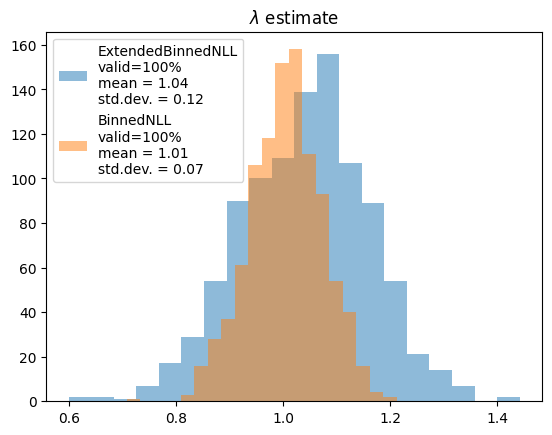

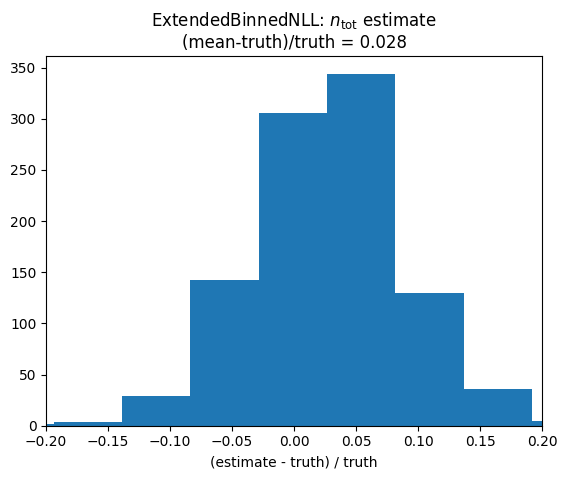

In [32]:
plt.figure()
plt.title("$\\lambda$ estimate")
plt.hist(
    lambd1,
    bins=20,
    alpha=0.5,
    label=f"ExtendedBinnedNLL\nvalid={np.mean(valid1)*100:.0f}%\nmean = {np.mean(lambd1):.2f}\nstd.dev. = {np.std(lambd1):.2f}",
)
plt.hist(
    lambd2,
    bins=20,
    alpha=0.5,
    label=f"BinnedNLL\nvalid={np.mean(valid2)*100:.0f}%\nmean = {np.mean(lambd2):.2f}\nstd.dev. = {np.std(lambd2):.2f}",
)
plt.legend()

plt.figure()
plt.hist(ntot1 / ntot - 1)
plt.title(
    f"ExtendedBinnedNLL: $n_\\mathrm{{tot}}$ estimate\n(mean-truth)/truth = {np.mean(ntot1) / np.mean(ntot) - 1:.3f}"
)
plt.xlabel("(estimate - truth) / truth")
plt.xlim(-0.2, 0.2);

As expected, we find that the estimates of $\lambda$ have low bias, although they are not perfectly unbiased.

The variance of $\lambda$ is smaller for `BinnedNLL`. If you are not interested in the amplitude of the distribution, it is therefore better to use `BinnedNLL` for weighted histograms. Note that `BinnedNLL` and `ExtendedBinnedNLL` internally use the same cost function for weighted data, so the difference in precision originates from the additional information used in `BinnedNLL`, that the sample is complete, there are no further events in other bins.

The second plot shows the estimate of the total sum of weights with `ExtendedBinnedNLL`, which is distributed around the true value. We observe a small upward bias of 2%.

We claim above that estimates for our chosen cost function are unbiased, while these results show small bias. There are two reasons for that. i) The cost Bohm-Zech approach does not guarantee unbiasedness anymore, since we must estimate $s$ from the information in the bin, and the empirical estimate for $s$ that we use is not an unbiased estimate of the true value, because it is a non-linear function of the weights. ii) The unbiasedness was claimed for the bin expectations and linear functions thereof. The model parameter $\lambda$ is not a linear function of the bin expectations, therefore it is also not guaranteed to be unbiased. We will come back to this point below.

We further said that the minimum value is no longer chi-square distributed when bins with negative sums of weights are fitted, so let's look at the actual distribution of the minimum value of the cost function.

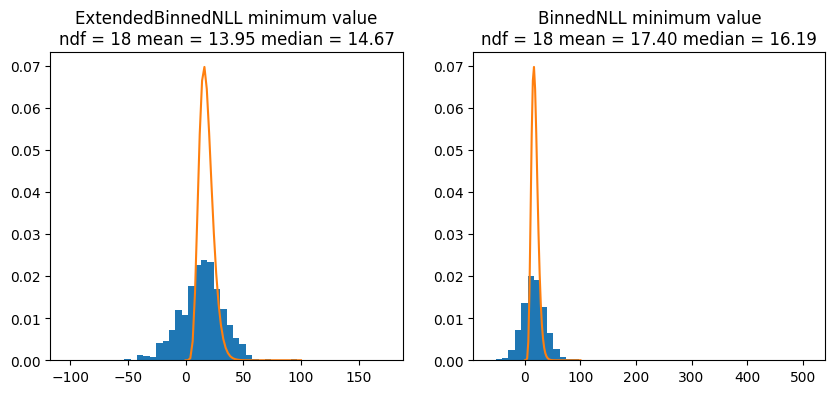

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(ax[0])
plt.hist(minval1, bins=50, density=True)
x = np.linspace(0, 100)
plt.plot(x, chi2(bins - 2).pdf(x))
plt.title(
    f"ExtendedBinnedNLL minimum value\nndf = {bins-2} mean = {np.mean(minval1):.2f} median = {np.median(minval1):.2f}"
)

plt.sca(ax[1])
plt.hist(minval2, bins=50, density=True)
x = np.linspace(0, 100)
plt.plot(x, chi2(bins - 2).pdf(x))
plt.title(
    f"BinnedNLL minimum value\nndf = {bins-2} mean = {np.mean(minval2):.2f} median = {np.median(minval2):.2f}"
);

We find that these distributions are broader than the asymptotical chi-square distribution and contain negative values, as expected. One can qualitatively still use very large values compared ot the expected mean as evidence for a bad fit, however, since bins with $w < 0$ only reduce the function minimum value.

For reference, it is interesting to run the toy experiment again with a very narrow weight distribution. We expect that the bias largely disappears, as our original toy experiment with its broad weight distribution was designed to be challenging. For this run, we draw the weights from a narrow normal distribution with constant width of 0.01.

In [34]:
def run(seed):
    rng = np.random.default_rng(seed)
    # we also randomize the sample size
    x = expon.rvs(size=rng.poisson(npoints), random_state=rng)
    w = rng.normal(0.1, 0.01, size=len(x))

    h = bh.Histogram(
        bh.axis.Regular(bins, np.min(x), np.max(x)), storage=bh.storage.Weight()
    )
    h.fill(x, weight=w)
    xe = h.axes[0].edges
    n = h.values()
    vn = h.variances()
    data = np.transpose((n, vn))
    ntot = np.sum(n)

    m1 = Minuit(ExtendedBinnedNLL(data, xe, model1), ntot, 0.6)
    m1.limits[0] = (0, None)
    m1.limits[1] = (0, None)
    m1.migrad()

    m2 = Minuit(BinnedNLL(data, xe, model2), 0.6)
    m2.limits = (0, None)
    m2.migrad()

    return (
        ntot,
        m1.valid,
        m1.values[0],
        m1.values[1],
        m1.fval,
        m2.valid,
        m2.values[0],
        m2.fval,
    )


result = Parallel(n_jobs=8)(delayed(run)(seed) for seed in range(1000))
ntot, valid1, ntot1, lambd1, minval1, valid2, lambd2, minval2 = np.transpose(result)

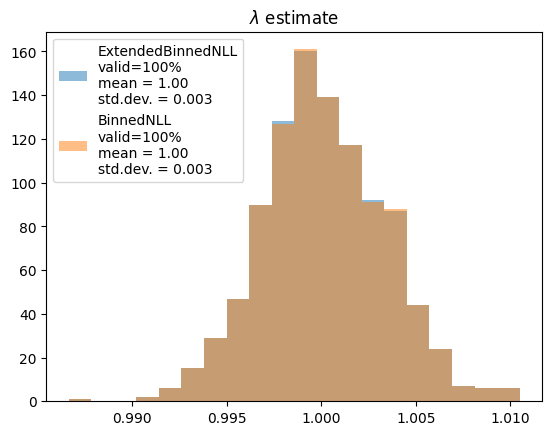

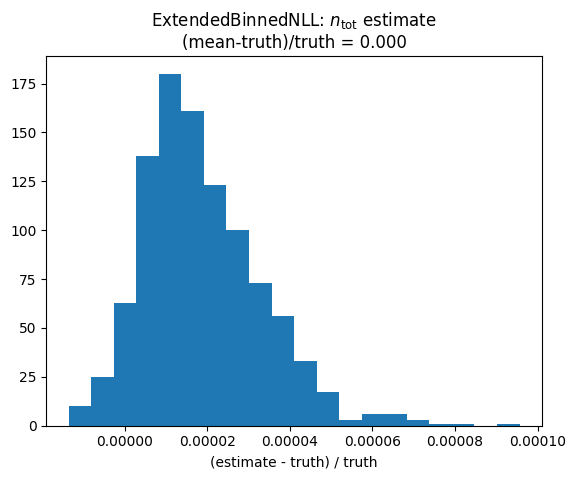

In [35]:
plt.figure()
plt.title("$\\lambda$ estimate")
plt.hist(
    lambd1,
    bins=20,
    alpha=0.5,
    label=f"ExtendedBinnedNLL\nvalid={np.mean(valid1)*100:.0f}%\nmean = {np.mean(lambd1):.2f}\nstd.dev. = {np.std(lambd1):.3f}",
)
plt.hist(
    lambd2,
    bins=20,
    alpha=0.5,
    label=f"BinnedNLL\nvalid={np.mean(valid2)*100:.0f}%\nmean = {np.mean(lambd2):.2f}\nstd.dev. = {np.std(lambd2):.3f}",
)
plt.legend()

plt.figure()
plt.hist(ntot1 / ntot - 1, bins=20)
plt.title(
    f"ExtendedBinnedNLL: $n_\\mathrm{{tot}}$ estimate\n(mean-truth)/truth = {np.mean(ntot1) / np.mean(ntot) - 1:.3f}"
)
plt.xlabel("(estimate - truth) / truth");

We now find negligible bias for $\lambda$ and $n_\text{tot}$. The precision is also greatly improved, since the weight distribution is so narrow that it can effectively be neglected as a source of additional uncertainty to the underlying Poisson process.

The estimates from `ExtendedBinnedNLL` and `BinnedNLL` for $\lambda$ become equal in this case (and their precision), because the ordinary likelihood for unweighted samples factorizes into a part for $n_\text{tot}$ and another for $\lambda$. This means that the estimates for $n_\text{tot}$ and $\lambda$ are independent. This factorization is broken for weighted histograms in general, and only restored here, because the weight variance is negligible.

Finally, we have another look at the function minimum values.

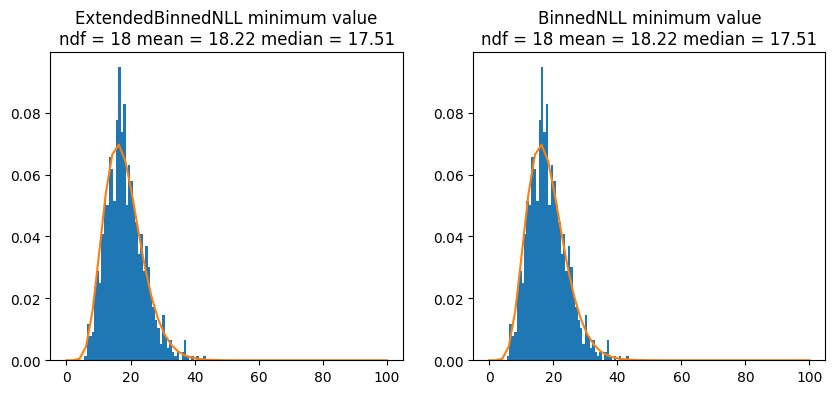

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(ax[0])
plt.hist(minval1, bins=50, density=True)
x = np.linspace(0, 100)
plt.plot(x, chi2(bins - 2).pdf(x))
plt.title(
    f"ExtendedBinnedNLL minimum value\nndf = {bins-2} mean = {np.mean(minval1):.2f} median = {np.median(minval1):.2f}"
)

plt.sca(ax[1])
plt.hist(minval2, bins=50, density=True)
x = np.linspace(0, 100)
plt.plot(x, chi2(bins - 2).pdf(x))
plt.title(
    f"BinnedNLL minimum value\nndf = {bins-2} mean = {np.mean(minval2):.2f} median = {np.median(minval2):.2f}"
);

The minimum values now follow the theoretical chi-square distribution very well, since bins with a negative sum of weights do not occur anymore.